## Evaluation of Adnet Client Requests

### Statistics of Interest
#### Setting
- we have tested for
  - 40 potential vulnerabilities/configurations
  - 7 different algorithms (required also for vulnerability assessments)
  - (explicit session finish)
  - ~legacy downgrade vulnerabilities~ (contained in the 40 vulnerabilities)

#### Statistics and Plots
- "impact" of the different vulnerabilities
  - as expressed by share of users vulnerable to them
  - represented by ???-plot (40 vulns to cover...)
- "competibility" of the different vulnerabilities
  - as expressed by their share among the total number of individual vulnerabilities found
- 

### Evaluations Sketch
- load request log file to DF
- create complete request matrix for each of the resolvers and domains (ip, d1, d2, d3, d4)
- determine from request matrix for each (resolver, user)-tuple
  - has session finised
  - for each algorithm: supports algorithm
  - validates dnssec ("broken"; combination of algorithm support)
  - for each vulnerability check: is vulnerable

In [1]:
%%bash
ls -lh ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3*.json

-rw-rw-r-- 1 nils nils  20M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-AF.json
-rw-rw-r-- 1 nils nils  15M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-AS2.json
-rw-rw-r-- 1 nils nils  16M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-AS.json
-rw-rw-r-- 1 nils nils  17M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-EU2.json
-rw-rw-r-- 1 nils nils  13M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-EU.json
-rw-rw-r-- 1 nils nils 2.0M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-EU-leftovers.json
-rw-rw-r-- 1 nils nils  14M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-NA.json
-rw-rw-r-- 1 nils nils  41M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-OC.json
-rw-rw-r-- 1 nils nils  14M Nov 23 18:04 ../../dnssec-downgrade-data/2021-10-06_adnet-study/adnet3-SA.json


In [2]:
import pandas as pd
import numpy as np
from urllib import parse
# import logging
import matplotlib as plt
import seaborn as sns
import matplotlib.ticker as mtick
import logging

# pd.options.display.max_rows = 2000
pd.options.display.max_columns = 2000
# logging.getLogger('matplotlib.font_manager').disabled = True

pd.options.plotting.backend = 'matplotlib'
plt.style.use('ggplot')

REPO_DIR = '../../dnssec-downgrade-data/'
DATA_DIR = REPO_DIR + '/2021-10-06_adnet-study/'  # location of input/raw and processed data
STATS_DIR = DATA_DIR + '/stats/' # output location fo tables and plots 

IP_VICTIM = '104.238.214.165'
IP_ATTACKER = '104.238.214.154'

# LOGFILE_DEV = DATA_DIR + '/dev-adnet.json' # proper subset of EU logfile
LOGFILE_EU = DATA_DIR + '/adnet3-EU2.json' # EU2? EU-leftovers?
LOGFILE_AF = DATA_DIR + '/adnet3-AF.json'
LOGFILE_SA = DATA_DIR + '/adnet3-SA.json'
LOGFILE_NA = DATA_DIR + '/adnet3-NA.json'
LOGFILE_OC = DATA_DIR + '/adnet3-OC.json'
LOGFILE_AS = DATA_DIR + '/adnet3-AS.json' # AS2?

# Regions
R_DEV = "dev"
R_EU = "eu"  # Europe
R_AF = "af"  # Africa
R_SA = "sa"  # South America
R_NA = "na"  # North America
R_OC = "oc"  # Oceania
R_AS = "as"  # Asia
REGIONS = [
    # R_DEV,
    R_EU,
    R_AF,
    R_SA,
    R_NA,
    R_OC,
    R_AS,
]
REGIONS_TO_LOGFILES = {
    # R_DEV: LOGFILE_DEV,
    R_EU: LOGFILE_EU,
    R_AF: LOGFILE_AF,
    R_SA: LOGFILE_SA,
    R_NA: LOGFILE_NA,
    R_OC: LOGFILE_OC,
    R_AS: LOGFILE_AS,
}


STUDY_DOMAINS = {  # Must not be FQDN!
    "resolver-downgrade-attack.dedyn.io",
    "downgrade.dedyn.io"
}

TEST_NAMES = {
    # Downgrade Vulnerabilities
    "mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16",
    "mitm-ra-ds8-ds13.ds8-ds15-dnskey15",
    "mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16",
    "mitm-ra-ds8-ds13-ds15.ds16",
    "mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15",
    "mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16",
    "mitm-ra-ds8-ds13-ds15-ds16.ds16",
    "mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15",
    "mitm-rs13-ra.ds8-ds16-dnskey16",
    "mitm-rs13-ra.ds8-ds13-dnskey8",
    "mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15",
    "mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16",
    "mitm-rs13-ra.ds16",
    "mitm-rs15-ra.ds8-ds16-dnskey16",
    "mitm-rs15-ra.ds8-ds13-dnskey13",
    "mitm-rs15-ra.ds8-dnskey8",
    "mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16",
    "mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16",
    "mitm-rs15-ra.ds16",
    "mitm-rs15-ra.ds8-ds16-dnskey16",
    "mitm-rs15-ra.ds8-ds15-dnskey15",
    "mitm-rs16-ra.ds8-ds13-dnskey13",
    "mitm-rs16-ra.ds15-ds16-dnskey15",
    "mitm-rs16-ra.ds13-ds16-dnskey16",
    "mitm-rs16-ra.ds13-ds16-dnskey13-dnskey16",
    "mitm-rs16-ra.ds8-ds13-dnskey8",
    "mitm-rs16-ra.ds8-ds15-dnskey8-dnskey15",
    "mitm-rs16-ra.ds13-dnskey13",
    "mitm-rs16-ra.ds8-ds13-dnskey8-dnskey13",
    "mitm-rs16-ra.ds13-ds15-dnskey15",
    "mitm-rs8-ra.ds8-ds16-dnskey16",
    "mitm-rs8-ra.ds15-ds16-dnskey16",
    "mitm-rs8-ra.ds13-ds16-dnskey16",
    "mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16",
    "mitm-rs8-ra.ds13-dnskey13",
    "mitm-rs8-ra.ds13-ds15-dnskey13-dnskey15",
    "mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13",
    "mitm-rs8-ra.ds8-dnskey8",
    "mitm-rs8-ra.ds16",
    "mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16",
    
    # Algorithm Support
    "mitm-ra.ds5-dnskey5",
    "mitm-ra.ds8-dnskey8",
    "mitm-ra.ds10-dnskey10",
    "mitm-ra.ds13-dnskey13",
    "mitm-ra.ds14-dnskey14",
    "mitm-ra.ds15-dnskey15",
    "mitm-ra.ds16-dnskey16",
    
    # Legacy Downgrade Vulnerabilities (actually covered by non-legacy)
    # "ecdsap256sha256",
    # "onlyrsasha256",
    # "rsasha256",
    
    # Housekeeping
    "broken",
    "session-finish",  # substitute for empty child / parent domain
}

### Load Request Data

In [3]:
region_dfs = [pd.read_json(REGIONS_TO_LOGFILES[region], lines=True) for region in REGIONS]

df_req_raw = pd.concat(region_dfs, keys=REGIONS).reset_index(level=0).rename(mapper={"level_0": "region"}, axis=1)
df_req_raw

,region,time_epoch,time_human,ip_server,ip_client,request_method,protocol,host_header,server_alias,port_server,url_path,filename,query,time_served_ms,status,errlog_reqest_id,user_agent
0,eu,1637326892050,2021-11-19T13:01:32,104.238.214.165,34.77.162.11,GET,HTTP/1.1,ses1651692107-mitm-rs16-ra.ds13-dnskey13.downg...,localhost.localdomain,80,/index.html,/var/www/downgrade.dedyn.io/index.html,,297,200,-,Expanse indexes the network perimeters of our ...
1,eu,1637326892057,2021-11-19T13:01:32,104.238.214.165,34.77.162.11,GET,HTTP/1.1,ses2544388860-mitm-rs15-ra.ds16.downgrade.dedy...,localhost.localdomain,80,/index.html,/var/www/downgrade.dedyn.io/index.html,,282,200,-,Expanse indexes the network perimeters of our ...
2,eu,1637326908740,2021-11-19T13:01:48,104.238.214.165,185.208.223.34,GET,HTTP/1.1,adn3698285940-mitm-ra-ds8-ds13.ds13-ds16-dnske...,ds13-ds16-dnskey13-dnskey16.downgrade.dedyn.io,443,/img.png,/var/www/downgrade.dedyn.io/img.png,?test=mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnsk...,364,200,-,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....
3,eu,1637326908846,2021-11-19T13:01:48,104.238.214.165,185.208.223.34,GET,HTTP/1.1,adn3698285940-mitm-ra-ds8-ds13-ds15.ds13-ds16-...,ds13-ds16-dnskey13-dnskey16.downgrade.dedyn.io,443,/img.png,/var/www/downgrade.dedyn.io/img.png,?test=mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13...,379,200,-,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....
4,eu,1637326908859,2021-11-19T13:01:48,104.238.214.165,185.208.223.34,GET,HTTP/1.1,adn3698285940-mitm-ra-ds8-ds13-ds15.ds16.downg...,ds16.downgrade.dedyn.io,443,/img.png,/var/www/downgrade.dedyn.io/img.png,?test=mitm-ra-ds8-ds13-ds15.ds16&tok=adn369828...,283,200,-,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22931,as,1637326624207,2021-11-19T12:57:04,104.238.214.165,34.86.35.4,GET,HTTP/1.1,ses1675384372-mitm-rs16-ra.ds13-dnskey13.downg...,localhost.localdomain,80,/index.html,/var/www/downgrade.dedyn.io/index.html,,308,200,-,Expanse indexes the network perimeters of our ...
22932,as,1637326686163,2021-11-19T12:58:06,104.238.214.165,34.86.35.29,GET,HTTP/1.1,ses2006897150-mitm-rs15-ra.ds13-ds16-dnskey13-...,ds13-ds16-dnskey13-dnskey16.downgrade.dedyn.io,443,/index.html,/var/www/downgrade.dedyn.io/index.html,,427,200,-,Expanse indexes the network perimeters of our ...
22933,as,1637326686246,2021-11-19T12:58:06,104.238.214.165,34.86.35.29,GET,HTTP/1.1,ses2144262284-mitm-ra.ds10-dnskey10.downgrade....,ds10-dnskey10.downgrade.dedyn.io,443,/index.html,/var/www/downgrade.dedyn.io/index.html,,423,200,-,Expanse indexes the network perimeters of our ...
22934,as,1637326724588,2021-11-19T12:58:44,104.238.214.165,34.77.162.19,GET,HTTP/1.1,ses383228517-mitm-rs13-ra.ds8-ds15-dnskey8-dns...,localhost.localdomain,80,/index.html,/var/www/downgrade.dedyn.io/index.html,,296,200,-,Expanse indexes the network perimeters of our ...


#### Remove Irrelevant Columns

In [4]:
df_req_reduced = df_req_raw[['region', 'query', 'ip_server']]
df_req_reduced

,region,query,ip_server
0,eu,,104.238.214.165
1,eu,,104.238.214.165
2,eu,?test=mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnsk...,104.238.214.165
3,eu,?test=mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13...,104.238.214.165
4,eu,?test=mitm-ra-ds8-ds13-ds15.ds16&tok=adn369828...,104.238.214.165
...,...,...,...
22931,as,,104.238.214.165
22932,as,,104.238.214.165
22933,as,,104.238.214.165
22934,as,,104.238.214.165


#### Expand Data From Query Parameter

In [5]:
def splitq(df):
    test = np.nan
    token = np.nan
    time = np.nan
    query = df['query']
    if query is not None and len(query) > 1:
        params = dict(parse.parse_qsl(query[1:]))
        test = params.get('test')
        token = str(params.get('tok'))
        time = params.get('time')
    return test, token, time
        

df_req_qsplit = df_req_reduced.copy(deep=True)
df_req_qsplit[['test', 'token', 'time_client']] = df_req_qsplit.apply(axis=1, func=splitq, result_type='expand')
df_req_qsplit = df_req_qsplit.drop(columns=['query'])
df_req_qsplit

,region,ip_server,test,token,time_client
0,eu,104.238.214.165,NaN,NaN,NaN
1,eu,104.238.214.165,NaN,NaN,NaN
2,eu,104.238.214.165,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,adn3698285940,1637326919477
3,eu,104.238.214.165,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,adn3698285940,1637326919478
4,eu,104.238.214.165,mitm-ra-ds8-ds13-ds15.ds16,adn3698285940,1637326919478
...,...,...,...,...,...
22931,as,104.238.214.165,NaN,NaN,NaN
22932,as,104.238.214.165,NaN,NaN,NaN
22933,as,104.238.214.165,NaN,NaN,NaN
22934,as,104.238.214.165,NaN,NaN,NaN


#### Remove Queries that Don't Belong to a Test

In [6]:
df_req_qsplit_clean = df_req_qsplit.dropna()
seen_tests = df_req_qsplit_clean['test'].unique()
print(f"Seen tests ({len(seen_tests)}):\n{sorted(seen_tests)}".replace(",", ",\n"))
# sorted()

Seen tests (46):
['mitm-ra-ds8-ds13-ds15-ds16.ds16',
 'mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15',
 'mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16',
 'mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16',
 'mitm-ra-ds8-ds13-ds15.ds16',
 'mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15',
 'mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16',
 'mitm-ra-ds8-ds13.ds8-ds15-dnskey15',
 'mitm-ra.ds10-dnskey10',
 'mitm-ra.ds13-dnskey13',
 'mitm-ra.ds14-dnskey14',
 'mitm-ra.ds15-dnskey15',
 'mitm-ra.ds16-dnskey16',
 'mitm-ra.ds5-dnskey5',
 'mitm-ra.ds8-dnskey8',
 'mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16',
 'mitm-rs13-ra.ds16',
 'mitm-rs13-ra.ds8-ds13-dnskey8',
 'mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15',
 'mitm-rs13-ra.ds8-ds16-dnskey16',
 'mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16',
 'mitm-rs15-ra.ds16',
 'mitm-rs15-ra.ds8-dnskey8',
 'mitm-rs15-ra.ds8-ds13-dnskey13',
 'mitm-rs15-ra.ds8-ds15-dnskey15',
 'mitm-rs15-ra.ds8-ds16-dnskey16',
 'mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16',
 'mitm-rs16-ra.ds13-dnskey13',


#### Aggregate over Clients the Tests that had Queries at the Web Server

In [7]:
df_req_clients = df_req_qsplit_clean[['token', 'test', 'ip_server']]
df_req_clients

# for name, group in request_df_clients:
#     print(f"{name}\n{group}\n")

,token,test,ip_server
2,adn3698285940,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,104.238.214.165
3,adn3698285940,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,104.238.214.165
4,adn3698285940,mitm-ra-ds8-ds13-ds15.ds16,104.238.214.165
5,adn3698285940,mitm-ra-ds8-ds13.ds8-ds15-dnskey15,104.238.214.165
6,adn3698285940,mitm-ra-ds8-ds13-ds15-ds16.ds16,104.238.214.165
...,...,...,...
22893,adn3056690742,mitm-ra-ds8-ds13.ds8-ds15-dnskey15,104.238.214.165
22894,adn3056690742,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,104.238.214.165
22895,adn3056690742,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,104.238.214.165
22896,adn3056690742,mitm-ra-ds8-ds13-ds15.ds16,104.238.214.165


In [8]:
df_req_clients_queries_groupby = df_req_clients[['token', 'test', 'ip_server']].groupby('token')

# dirty but does the job...
newdf_v = []
for name, group in df_req_clients_queries_groupby:
    assert len(set(group['token'].values)) == 1
    token = group['token'].values[0]
    requests_present = dict((test_name, test_name in group['test'].values) for test_name in TEST_NAMES)
    newdf_v.append({'token': token, **requests_present})
df_request_presence = pd.DataFrame(newdf_v)
df_request_presence = df_request_presence.set_index('token')
df_request_presence

,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra.ds5-dnskey5,mitm-ra.ds15-dnskey15,mitm-rs15-ra.ds8-dnskey8,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15,mitm-rs16-ra.ds8-ds13-dnskey13,mitm-ra-ds8-ds13.ds8-ds15-dnskey15,broken,mitm-ra-ds8-ds13-ds15-ds16.ds16,mitm-rs16-ra.ds13-ds16-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16,mitm-rs16-ra.ds15-ds16-dnskey15,mitm-rs8-ra.ds13-ds15-dnskey13-dnskey15,mitm-rs8-ra.ds16,mitm-rs16-ra.ds13-dnskey13,mitm-rs8-ra.ds13-dnskey13,mitm-rs15-ra.ds8-ds13-dnskey13,mitm-rs16-ra.ds8-ds15-dnskey8-dnskey15,mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15,mitm-rs15-ra.ds8-ds15-dnskey15,mitm-ra.ds13-dnskey13,mitm-ra.ds14-dnskey14,mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8-dnskey13,mitm-ra.ds8-dnskey8,mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13-ds15.ds16,mitm-rs13-ra.ds8-ds13-dnskey8,mitm-ra.ds10-dnskey10,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,mitm-ra.ds16-dnskey16,mitm-rs8-ra.ds15-ds16-dnskey16,mitm-rs15-ra.ds16,mitm-rs8-ra.ds13-ds16-dnskey16,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,session-finish,mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8,mitm-rs13-ra.ds16,mitm-rs8-ra.ds8-ds16-dnskey16,mitm-rs16-ra.ds13-ds15-dnskey15,mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15,mitm-rs8-ra.ds8-dnskey8,mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16,mitm-rs13-ra.ds8-ds16-dnskey16,mitm-rs15-ra.ds8-ds16-dnskey16
token,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1751145853,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,True,False,True,False,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False
799623589,True,True,True,True,False,True,False,False,True,False,False,True,True,True,True,True,True,False,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,False,False,False,True,False,True,False,False,True,True,True,False,False
adn1000260028,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
adn1000520564,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
adn1000690753,True,False,False,True,True,True,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adn998043898,False,False,False,True,True,False,True,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,True,True
adn998166374,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,False,True,False,True,True,True
adn998799604,True,True,True,True,True,True,False,False,True,False,True,True,False,True,False,False,False,False,False,True,True,True,False,False,True,False,True,True,False,True,False,True,False,False,True,True,True,False,True,False,False,True,False,False,True,False,False,True


### Infer Resolver Properties

#### Filter for Finished Sessions

In [9]:
def single_value(s):
    if len(set(s)) > 1:
        logging.warning(f'different regions for the same token: {set(s)}')
    return next(iter(s))

df_token_region = df_req_qsplit.groupby('token').agg({'region': [single_value]}).reset_index()
df_token_region.columns = df_token_region.columns.droplevel(1)
df_token_region = df_token_region.set_index('token')

In [10]:
df_finished_sessions = df_request_presence.copy(deep=True)
df_finished_sessions = df_finished_sessions[df_finished_sessions['session-finish'] == True]  # keep only those with finished session
# request_df_rp_fin = request_df_rp_fin.drop(columns=['finish'])
df_finished_sessions

,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra.ds5-dnskey5,mitm-ra.ds15-dnskey15,mitm-rs15-ra.ds8-dnskey8,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15,mitm-rs16-ra.ds8-ds13-dnskey13,mitm-ra-ds8-ds13.ds8-ds15-dnskey15,broken,mitm-ra-ds8-ds13-ds15-ds16.ds16,mitm-rs16-ra.ds13-ds16-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16,mitm-rs16-ra.ds15-ds16-dnskey15,mitm-rs8-ra.ds13-ds15-dnskey13-dnskey15,mitm-rs8-ra.ds16,mitm-rs16-ra.ds13-dnskey13,mitm-rs8-ra.ds13-dnskey13,mitm-rs15-ra.ds8-ds13-dnskey13,mitm-rs16-ra.ds8-ds15-dnskey8-dnskey15,mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15,mitm-rs15-ra.ds8-ds15-dnskey15,mitm-ra.ds13-dnskey13,mitm-ra.ds14-dnskey14,mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8-dnskey13,mitm-ra.ds8-dnskey8,mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13-ds15.ds16,mitm-rs13-ra.ds8-ds13-dnskey8,mitm-ra.ds10-dnskey10,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,mitm-ra.ds16-dnskey16,mitm-rs8-ra.ds15-ds16-dnskey16,mitm-rs15-ra.ds16,mitm-rs8-ra.ds13-ds16-dnskey16,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,session-finish,mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8,mitm-rs13-ra.ds16,mitm-rs8-ra.ds8-ds16-dnskey16,mitm-rs16-ra.ds13-ds15-dnskey15,mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15,mitm-rs8-ra.ds8-dnskey8,mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16,mitm-rs13-ra.ds8-ds16-dnskey16,mitm-rs15-ra.ds8-ds16-dnskey16
token,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
adn1000260028,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
adn1000520564,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
adn1000690753,True,False,False,True,True,True,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
adn1002312047,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
adn1002854933,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adn995177836,True,True,True,True,True,True,True,False,False,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,False,False,True,True,True,True,False,False,True,True,True,True,False,False
adn995419537,True,False,True,False,False,False,False,False,True,True,False,True,False,True,True,False,True,True,True,False,True,True,False,True,True,True,False,False,True,True,True,False,True,False,False,False,True,True,True,False,False,False,True,True,True,False,False,True
adn996144029,True,True,True,True,True,False,True,False,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True


#### Filter for DNSSEC Validation

See [RFC8624](https://datatracker.ietf.org/doc/html/rfc8624#section-3.1) for algo support specification.

In [11]:
print(f"For {(~df_finished_sessions['broken']).mean():.1%} of users, we did not see a request on the domain name with broken DNSSEC.")

For 100.0% of users, we did not see a request on the domain name with broken DNSSEC.


In [12]:
df_validating_resolvers = df_finished_sessions.join(df_token_region, on='token').groupby(['region']).agg({
    'broken': [lambda s: 1 - s.mean()],
})
df_validating_resolvers.columns = ['users using validating resolvers']
df_validating_resolvers.style.format(lambda v: f"{v:.1%}")

,users using validating resolvers
region,
af,100.0%
as,100.0%
eu,100.0%
na,100.0%
oc,100.0%
sa,100.0%


In [13]:
df_validators = df_finished_sessions[~df_finished_sessions['broken']]
df_validators
# request_df_rp_fin_do = request_df_rp_fin

,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra.ds5-dnskey5,mitm-ra.ds15-dnskey15,mitm-rs15-ra.ds8-dnskey8,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15,mitm-rs16-ra.ds8-ds13-dnskey13,mitm-ra-ds8-ds13.ds8-ds15-dnskey15,broken,mitm-ra-ds8-ds13-ds15-ds16.ds16,mitm-rs16-ra.ds13-ds16-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16,mitm-rs16-ra.ds15-ds16-dnskey15,mitm-rs8-ra.ds13-ds15-dnskey13-dnskey15,mitm-rs8-ra.ds16,mitm-rs16-ra.ds13-dnskey13,mitm-rs8-ra.ds13-dnskey13,mitm-rs15-ra.ds8-ds13-dnskey13,mitm-rs16-ra.ds8-ds15-dnskey8-dnskey15,mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15,mitm-rs15-ra.ds8-ds15-dnskey15,mitm-ra.ds13-dnskey13,mitm-ra.ds14-dnskey14,mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8-dnskey13,mitm-ra.ds8-dnskey8,mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13-ds15.ds16,mitm-rs13-ra.ds8-ds13-dnskey8,mitm-ra.ds10-dnskey10,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,mitm-ra.ds16-dnskey16,mitm-rs8-ra.ds15-ds16-dnskey16,mitm-rs15-ra.ds16,mitm-rs8-ra.ds13-ds16-dnskey16,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,session-finish,mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8,mitm-rs13-ra.ds16,mitm-rs8-ra.ds8-ds16-dnskey16,mitm-rs16-ra.ds13-ds15-dnskey15,mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15,mitm-rs8-ra.ds8-dnskey8,mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16,mitm-rs13-ra.ds8-ds16-dnskey16,mitm-rs15-ra.ds8-ds16-dnskey16
token,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
adn1000260028,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
adn1000520564,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
adn1000690753,True,False,False,True,True,True,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
adn1002312047,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
adn1002854933,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adn995177836,True,True,True,True,True,True,True,False,False,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,False,False,True,True,True,True,False,False,True,True,True,True,False,False
adn995419537,True,False,True,False,False,False,False,False,True,True,False,True,False,True,True,False,True,True,True,False,True,True,False,True,True,True,False,False,True,True,True,False,True,False,False,False,True,True,True,False,False,False,True,True,True,False,False,True
adn996144029,True,True,True,True,True,False,True,False,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### Determine and Plot Statistics of Interest

In [14]:
ALGORITHMS = [5, 8, 10, 13, 14, 15, 16]

In [15]:
for a in ALGORITHMS:
    df_validators[f'supports_{a}'] = ~df_validators[f'mitm-ra.ds{a}-dnskey{a}']

In [16]:
del df_validators['session-finish']
del df_validators['broken']

In [17]:
df_requests = df_validators.reset_index().melt(id_vars=['token'] + [f'supports_{a}' for a in ALGORITHMS], var_name='zone', value_name='request')

In [18]:
df_requests.head(3)

,token,supports_5,supports_8,supports_10,supports_13,supports_14,supports_15,supports_16,zone,request
0,adn1000260028,False,False,False,False,False,False,False,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,True
1,adn1000520564,True,False,True,False,True,False,True,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,False
2,adn1000690753,True,False,False,False,False,True,False,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,True


In [19]:
df_requests['attack'] = df_requests.apply(lambda row: row['zone'].split('.')[0], axis=1)
df_requests['zone_prefix'] = df_requests.apply(lambda row: row['zone'].split('.')[1], axis=1)
df_requests['ds'] = df_requests.apply(lambda row: tuple(a for a in ALGORITHMS if f'ds{a}' in row['zone_prefix']), axis=1)
df_requests['dnskey'] = df_requests.apply(lambda row: tuple(a for a in ALGORITHMS if f'dnskey{a}' in row['zone_prefix']), axis=1)
df_requests['support'] = df_requests.apply(lambda row: tuple(a for a in ALGORITHMS if row[f'supports_{a}']), axis=1)
df_requests['validation_path'] = df_requests.apply(lambda row: tuple(set(row['ds']) & set(row['dnskey'])), axis=1)
df_requests['supported_validation_path'] = df_requests.apply(lambda row: tuple(set(row['validation_path']) & set(row['support'])), axis=1)
df_requests['supported_ds'] = df_requests.apply(lambda row: tuple(set(row['ds']) & set(row['support'])), axis=1)
df_requests['evil_content'] = df_requests.apply(lambda row: '-ra' in row['attack'] or '-at' in row['attck'], axis=1)

In [20]:
def behavior_correct(row):
    if row['supported_ds'] and row['evil_content']:
        # there are supported DS records and we delivered evil content, correct behavior is SERVFAIL
        return not row['request']
    
    if not row['supported_ds']:
        # there are no supported DS algorithms, hence this must be treated as insecure, correct behavior is NOERROR
        return row['request']
    
    return None

df_requests['behavior_correct'] = df_requests.apply(behavior_correct, axis=1)
df_requests[df_requests['behavior_correct'].isna()][['attack', 'ds', 'support', 'supported_validation_path', 'supported_ds', 'evil_content', 'request']]

,attack,ds,support,supported_validation_path,supported_ds,evil_content,request


In [21]:
df_requests = df_requests.join(df_token_region, on='token')

In [22]:
df_requests.head(3)

,token,supports_5,supports_8,supports_10,supports_13,supports_14,supports_15,supports_16,zone,request,attack,zone_prefix,ds,dnskey,support,validation_path,supported_validation_path,supported_ds,evil_content,behavior_correct,region
0,adn1000260028,False,False,False,False,False,False,False,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,True,mitm-rs13-ra,ds13-ds16-dnskey13-dnskey16,"(13, 16)","(13, 16)",(),"(16, 13)",(),(),True,True,eu
1,adn1000520564,True,False,True,False,True,False,True,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,False,mitm-rs13-ra,ds13-ds16-dnskey13-dnskey16,"(13, 16)","(13, 16)","(5, 10, 14, 16)","(16, 13)","(16,)","(16,)",True,True,af
2,adn1000690753,True,False,False,False,False,True,False,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,True,mitm-rs13-ra,ds13-ds16-dnskey13-dnskey16,"(13, 16)","(13, 16)","(5, 15)","(16, 13)",(),(),True,True,sa


In [23]:
df_requests['num_ds'] = df_requests.apply(lambda row: len(row['ds']), axis=1)
df_requests['num_supported_ds'] = df_requests.apply(lambda row: len(row['supported_ds']), axis=1)
df_requests['num_unsupported_ds'] = df_requests.apply(lambda row: row['num_ds'] - row['num_supported_ds'], axis=1)

In [24]:
def rrsig(row):
    if '-rs' in row['attack'] and '-ds' in row['attack']:
        raise NotImplemented
    if '-rs' in row['attack']:
        for a in ALGORITHMS:
            if f'-rs{a}' in row['attack']:
                return tuple([a])
    if '-ds' in row['attack']:
        return tuple(set(row['ds']) - {a for a in ALGORITHMS if f'ds{a}' in row['attack']})
    return row['ds']

df_requests['rrsig'] = df_requests.apply(rrsig, axis=1)

In [25]:
df_requests['supported_rrsig'] = df_requests.apply(lambda row: tuple(set(row['rrsig']) & set(row['support'])), axis=1)
df_requests['num_rrsig'] = df_requests.apply(lambda row: len(row['rrsig']), axis=1)
df_requests['num_supported_rrsig'] = df_requests.apply(lambda row: len(row['supported_rrsig']), axis=1)
df_requests['num_unsupported_rrsig'] = df_requests.apply(lambda row: row['num_rrsig'] - row['num_supported_rrsig'], axis=1)
df_requests['has_supported'] = df_requests.apply(lambda row: row['num_rrsig'] - row['num_supported_rrsig'], axis=1)

In [26]:
df_requests['has_supported_ds'] = df_requests.apply(lambda row: bool(row['num_supported_ds']), axis=1)
df_requests['has_unsupported_ds'] = df_requests.apply(lambda row: bool(row['num_unsupported_ds']), axis=1)
df_requests['has_supported_rrsig'] = df_requests.apply(lambda row: bool(row['num_supported_rrsig']), axis=1)
df_requests['has_unsupported_rrsig'] = df_requests.apply(lambda row: bool(row['num_unsupported_rrsig']), axis=1)

In [27]:
df_affected_tokens = df_requests.groupby(['token', 'region']).agg({
    'behavior_correct': [min]
}).reset_index()
df_affected_tokens['has_any_vulnerability'] = ~df_affected_tokens[('behavior_correct', 'min')]
df_affected_tokens.columns = df_affected_tokens.columns.droplevel(1)
df_affected_tokens = df_affected_tokens.groupby(['region']).agg({
    'has_any_vulnerability': ['mean']
})
df_affected_tokens

,has_any_vulnerability
,mean
region,
af,0.986871
as,0.994580
eu,0.995381
na,0.996528
oc,0.962282
sa,0.987310


In [28]:
def user_rel(s):
    return f"{s.mean():.1%} ({s.sum():n} of {len(s)})"

vuln = 'user vulnerable to the following attack in at least one DS configuration'
by = ['region', 'attack']
df_affected_tokens = df_requests.groupby(['token'] + by).agg({
    'behavior_correct': [min]
}).reset_index()
df_affected_tokens[vuln] = ~df_affected_tokens[('behavior_correct', 'min')]
df_affected_tokens.columns = df_affected_tokens.columns.droplevel(1)
df_affected_tokens = df_affected_tokens.groupby(by).agg({
    vuln: [user_rel]
}).reset_index()
df_affected_tokens.columns = df_affected_tokens.columns.droplevel(1)
df_affected_tokens = df_affected_tokens.pivot(index=by[0], columns=by[1:], values=[vuln])
df_affected_tokens#.style.format(lambda v: f'{v:.1%}')

user vulnerable to the following attack in at least one DS configuration  \
attack                                                                  mitm-ra   
region                                                                            
af                                        0.0% (0 of 457)                         
as                                        0.0% (0 of 369)                         
eu                                        0.0% (0 of 433)                         
na                                        0.0% (0 of 288)                         
oc                                       0.0% (0 of 1087)                         
sa                                        0.0% (0 of 394)                         

                                                                              \
attack     mitm-ra-ds8-ds13 mitm-ra-ds8-ds13-ds15 mitm-ra-ds8-ds13-ds15-ds16   
region                                                                         
af       45.7% (209 of 457)    57.5% (263 of 457)         57.3% (262 of 457)   
as       37.4% (138 of 369)    44.4% (164 of 369)         36.3% (134 of 369)   
eu       51.3% (222 of 433)    63.0% (273 of 433)         61.9% (268 of 433)   
na       47.2% (136 of 288)    58.3% (168 of 288)         59.4% (171 of 288)   
oc      33.1% (360 of 1087)   46.7% (508 of 1087)        47.3% (514 of 1087)   
sa       59.4% (234 of 394)    74.1% (292 of 394)         73.9% (291 of 394)   

                                                                       \
attack         mitm-rs13-ra         mitm-rs15-ra         mitm-rs16-ra   
region                                                                  
af       64.3% (294 of 457)   66.1% (302 of 457)   64.8% (296 of 457)   
as       38.5% (142 of 369)   39.0% (144 of 369)   40.4% (149 of 369)   
eu       69.3% (300 of 433)   71.6% (310 of 433)   70.2% (304 of 433)   
na       64.9% (187 of 288)   67.0% (193 of 288)   62.8% (181 of 288)   
oc      49.1% (534 of 1087)  48.6% (528 of 1087)  39.3% (427 of 1087)   
sa       81.2% (320 of 394)   81.7% (322 of 394)   80.2% (316 of 394)   

                              
attack           mitm-rs8-ra  
region                        
af        92.8% (424 of 457)  
as        96.7% (357 of 369)  
eu        97.0% (420 of 433)  
na        97.2% (280 of 288)  
oc      93.6% (1017 of 1087)  
sa        95.2% (375 of 394)

In [29]:
def user_rel(s):
    return f"{s.mean():.1%} ({s.sum():n} of {len(s)})"

vuln = 'proportion of users vulnerable in at least one configuration matching the specified DS/RRSIG combination'
by = ['region', 'has_supported_ds', 'has_unsupported_ds', 'has_supported_rrsig', 'has_unsupported_rrsig']
df_affected_tokens = df_requests.groupby(['token'] + by).agg({
    'behavior_correct': [min]
}).reset_index()
df_affected_tokens[vuln] = ~df_affected_tokens[('behavior_correct', 'min')]
df_affected_tokens.columns = df_affected_tokens.columns.droplevel(1)
df_affected_tokens = df_affected_tokens.groupby(by).agg({
    vuln: [user_rel]
}).reset_index()
df_affected_tokens.columns = df_affected_tokens.columns.droplevel(1)
df_affected_tokens = df_affected_tokens.pivot(index=by[0], columns=by[1:], values=[vuln])
df_affected_tokens#.style.format(lambda v: f'{v:.1%}')

proportion of users vulnerable in at least one configuration matching the specified DS/RRSIG combination  \
has_supported_ds                                                                                                         False   
has_unsupported_ds                                                                                                        True   
has_supported_rrsig                                                                                                      False   
has_unsupported_rrsig                                                                                                    False   
region                                                                                                                           
af                                                    50.8% (169 of 333)                                                         
as                                                     25.8% (81 of 314)                                                         
eu                                                    40.7% (136 of 334)                                                         
na                                                    47.9% (114 of 238)                                                         
oc                                                    46.4% (448 of 965)                                                         
sa                                                    67.5% (185 of 274)                                                         

                                                                \
has_supported_ds                                                 
has_unsupported_ds                                               
has_supported_rrsig                                       True   
has_unsupported_rrsig                 True               False   
region                                                           
af                      83.0% (342 of 412)  88.2% (149 of 169)   
as                      89.8% (316 of 352)    69.7% (53 of 76)   
eu                      83.7% (339 of 405)  84.5% (174 of 206)   
na                      87.7% (242 of 276)   85.3% (93 of 109)   
oc                     96.0% (960 of 1000)    79.2% (76 of 96)   
sa                      78.6% (286 of 364)  86.6% (162 of 187)   

                                                               \
has_supported_ds                     True                       
has_unsupported_ds                  False                       
has_supported_rrsig                 False                       
has_unsupported_rrsig               False                True   
region                                                          
af                      52.3% (90 of 172)  79.7% (126 of 158)   
as                       66.7% (48 of 72)    81.7% (58 of 71)   
eu                     68.2% (105 of 154)  86.2% (175 of 203)   
na                       60.3% (44 of 73)   85.4% (88 of 103)   
oc                      43.1% (62 of 144)    75.3% (73 of 97)   
sa                     62.0% (106 of 171)  81.5% (154 of 189)   

                                                               \
has_supported_ds                                                
has_unsupported_ds                                       True   
has_supported_rrsig                  True               False   
has_unsupported_rrsig               False               False   
region                                                          
af                     63.7% (160 of 251)   54.1% (79 of 146)   
as                      66.1% (78 of 118)    75.0% (54 of 72)   
eu                     66.1% (187 of 283)  74.3% (142 of 191)   
na                      61.4% (89 of 145)    73.9% (65 of 88)   
oc                     54.0% (114 of 211)    50.6% (42 of 83)   
sa                     64.4% (179 of 278)  61.8% (102 of 165)   

                                                               
has_supported_ds                          

In [30]:
def vulnerable(row):
    return {
        True: False,
        False: True,
    }.get(row['behavior_correct'], None)

df_requests['vulnerable'] = df_requests.apply(vulnerable, axis=1)

In [31]:
# TODO replace with Elias' data
# values taken from Crawler Tranco
tranco_ds_distribution = {(1,): 4,
 (3,): 1,
 (5,): 882,
 (5, 7): 2,
 (5, 7, 8): 1,
 (5, 8): 20,
 (5, 10): 2,
 (5, 12): 1,
 (5, 13): 7,
 (7,): 1472,
 (7, 8): 8,
 (7, 8, 13, 14): 1,
 (7, 10): 1,
 (7, 13): 9,
 (8,): 21963,
 (8, 10): 5,
 (8, 13): 23,
 (8, 14): 1,
 (10,): 710,
 (10, 13): 2,
 (10, 14): 1,
 (12,): 2,
 (13,): 17862,
 (13, 15): 1,
 (14,): 267,
 (15,): 2}
tranco_ds_total = sum(c for c in tranco_ds_distribution.values())

# values taken from Crawler TLD
tld_ds_distribution = {(5,): 29, (7,): 34, (7, 8): 4, (8,): 1225, (10,): 33, (13,): 45}
tld_ds_total = sum(c for c in tld_ds_distribution.values())

In [32]:
_region_count_cache = {}

def count_region(r):
    if r not in _region_count_cache:
        _region_count_cache[r] = len(df_requests[df_requests['region'] == r]['token'].unique())
    return _region_count_cache[r]

def region(row):
    return {
        'af': 'Africa',
        'as': 'Asia',
        'eu': 'Europe',
        'na': 'North America',
        'oc': 'Oceania',
        'sa': 'South America',
    }.get(row['region'], row['region']) + f' (n={count_region(row["region"])})'

df_requests['Region'] = df_requests.apply(region, axis=1)

In [47]:
df_user_vuln = df_requests[df_requests['attack'] != 'mitm-ra'].groupby(['Region', 'ds', 'token']).agg(
    {'vulnerable': any}  # aggregation across attacks, hence using any
).groupby(['Region', 'ds']).agg(
    {'vulnerable': 'mean'}  # aggregation across users (tokens), hence using user_rel (mean)
).reset_index().sort_values(['Region', 'ds'])
df_user_vuln = df_user_vuln.pivot(index=['Region'], columns=['ds'], values=['vulnerable'])
df_user_vuln.columns = df_user_vuln.columns.droplevel(0)
df_user_vuln.style.format(lambda v: f"{v:.1%}")

ds,"(8,)","(8, 13)","(8, 15)","(8, 16)","(13,)","(13, 15)","(13, 16)","(15, 16)","(16,)"
Region,,,,,,,,,
Africa (n=457),37.4%,53.0%,58.2%,61.5%,38.5%,35.0%,67.4%,73.5%,55.4%
Asia (n=369),25.7%,42.8%,47.4%,42.5%,26.8%,24.7%,52.6%,86.4%,44.4%
Europe (n=433),46.2%,71.6%,72.3%,73.0%,46.4%,50.6%,73.9%,78.8%,68.4%
North America (n=288),40.3%,54.9%,60.1%,64.6%,35.8%,42.0%,67.0%,88.2%,53.5%
Oceania (n=1087),13.2%,23.2%,38.7%,41.6%,11.1%,26.6%,44.1%,92.1%,32.6%
South America (n=394),53.0%,73.6%,81.2%,82.0%,49.5%,47.2%,82.0%,69.8%,72.8%


In [34]:
df_user_vuln_total = df_requests[df_requests['attack'] != 'mitm-ra'].groupby(['ds', 'token']).agg(
    {'vulnerable': any}  # aggregation across attacks, hence using any
).groupby(['ds']).agg(
    {'vulnerable': 'mean'}  # aggregation across users (tokens), hence using user_rel (mean)
).reset_index().sort_values(['ds'])
df_user_vuln_total.columns = pd.Index(['ds', f"Global (n={len(df_requests['token'].unique())})"])
del df_user_vuln_total['ds']
df_user_vuln_total = df_user_vuln_total.T
df_user_vuln_total.columns = df_user_vuln.columns
df_user_vuln_total
#.style.format(lambda v: f"{v:.1%}")

ds,"(8,)","(8, 13)","(8, 15)","(8, 16)","(13,)","(13, 15)","(13, 16)","(15, 16)","(16,)"
Global (n=3028),0.308454,0.465654,0.550859,0.56638,0.295575,0.352048,0.600066,0.834214,0.498018


In [35]:
df_user_vuln_full = df_user_vuln.append(df_user_vuln_total)
df_user_vuln_full

ds,"(8,)","(8, 13)","(8, 15)","(8, 16)","(13,)","(13, 15)","(13, 16)","(15, 16)","(16,)"
Africa (n=457),0.374179,0.529540,0.582057,0.614880,0.385120,0.350109,0.673961,0.735230,0.553611
Asia (n=369),0.257453,0.428184,0.474255,0.425474,0.268293,0.246612,0.525745,0.864499,0.444444
Europe (n=433),0.461894,0.715935,0.722864,0.729792,0.464203,0.505774,0.739030,0.787529,0.683603
North America (n=288),0.402778,0.548611,0.600694,0.645833,0.357639,0.420139,0.670139,0.881944,0.534722
Oceania (n=1087),0.131555,0.231831,0.387305,0.415823,0.111316,0.265869,0.440662,0.920883,0.325667
South America (n=394),0.530457,0.736041,0.812183,0.819797,0.494924,0.472081,0.819797,0.697970,0.728426
Global (n=3028),0.308454,0.465654,0.550859,0.566380,0.295575,0.352048,0.600066,0.834214,0.498018


In [36]:
df_user_vuln_full.columns

Index([(8,), (8, 13), (8, 15), (8, 16), (13,), (13, 15), (13, 16), (15, 16),
       (16,)],
      dtype='object', name='ds')

In [37]:
df_user_vuln_full.columns = pd.MultiIndex.from_tuples(
    [(
        #'Prevalence of User Using Vulnerable Resolvers Conditioned on DS Algorithms and World Region', 
        ', '.join(str(int(a)) for a in x),
        f"{tranco_ds_distribution.get(x, 0)/tranco_ds_total:.0%}", 
        f"{tld_ds_distribution.get(x, 0)/tld_ds_total:.0%}"
    ) for x in df_user_vuln_full.columns],
    names=['DS Algorithms', 'Prevalence in Tranco 1M', 'Prevalence in TLDs']
)
df_user_vuln_full

DS Algorithms,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16","15, 16",16
Prevalence in Tranco 1M,51%,0%,0%,0%,41%,0%,0%,0%,0%
Prevalence in TLDs,89%,0%,0%,0%,3%,0%,0%,0%,0%
Africa (n=457),0.374179,0.529540,0.582057,0.614880,0.385120,0.350109,0.673961,0.735230,0.553611
Asia (n=369),0.257453,0.428184,0.474255,0.425474,0.268293,0.246612,0.525745,0.864499,0.444444
Europe (n=433),0.461894,0.715935,0.722864,0.729792,0.464203,0.505774,0.739030,0.787529,0.683603
North America (n=288),0.402778,0.548611,0.600694,0.645833,0.357639,0.420139,0.670139,0.881944,0.534722
Oceania (n=1087),0.131555,0.231831,0.387305,0.415823,0.111316,0.265869,0.440662,0.920883,0.325667
South America (n=394),0.530457,0.736041,0.812183,0.819797,0.494924,0.472081,0.819797,0.697970,0.728426
Global (n=3028),0.308454,0.465654,0.550859,0.566380,0.295575,0.352048,0.600066,0.834214,0.498018


In [38]:
formatters = {
    k: lambda v: f"{v:.1%}"
    for k in df_user_vuln.keys()
}
print(df_user_vuln_full.to_latex(index=True, formatters=formatters, float_format=lambda val: f"{val:.1%}", escape=True, na_rep='', column_format="l" + (len(df_user_vuln.keys())) * "r"))

\begin{tabular}{lrrrrrrrrr}
\toprule
DS Algorithms &     8 & 8, 13 & 8, 15 & 8, 16 &    13 & 13, 15 & 13, 16 & 15, 16 &    16 \\
Prevalence in Tranco 1M &   51\% &    0\% &    0\% &    0\% &   41\% &     0\% &     0\% &     0\% &    0\% \\
Prevalence in TLDs &   89\% &    0\% &    0\% &    0\% &    3\% &     0\% &     0\% &     0\% &    0\% \\
\midrule
Africa (n=457)        & 37.4\% & 53.0\% & 58.2\% & 61.5\% & 38.5\% &  35.0\% &  67.4\% &  73.5\% & 55.4\% \\
Asia (n=369)          & 25.7\% & 42.8\% & 47.4\% & 42.5\% & 26.8\% &  24.7\% &  52.6\% &  86.4\% & 44.4\% \\
Europe (n=433)        & 46.2\% & 71.6\% & 72.3\% & 73.0\% & 46.4\% &  50.6\% &  73.9\% &  78.8\% & 68.4\% \\
North America (n=288) & 40.3\% & 54.9\% & 60.1\% & 64.6\% & 35.8\% &  42.0\% &  67.0\% &  88.2\% & 53.5\% \\
Oceania (n=1087)      & 13.2\% & 23.2\% & 38.7\% & 41.6\% & 11.1\% &  26.6\% &  44.1\% &  92.1\% & 32.6\% \\
South America (n=394) & 53.0\% & 73.6\% & 81.2\% & 82.0\% & 49.5\% &  47.2\% &  82.0\% &  69.8\% & 7

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
df_user_vuln

ds,"(8,)","(8, 13)","(8, 15)","(8, 16)","(13,)","(13, 15)","(13, 16)","(15, 16)","(16,)"
Region,,,,,,,,,
Africa (n=457),0.374179,0.529540,0.582057,0.614880,0.385120,0.350109,0.673961,0.735230,0.553611
Asia (n=369),0.257453,0.428184,0.474255,0.425474,0.268293,0.246612,0.525745,0.864499,0.444444
Europe (n=433),0.461894,0.715935,0.722864,0.729792,0.464203,0.505774,0.739030,0.787529,0.683603
North America (n=288),0.402778,0.548611,0.600694,0.645833,0.357639,0.420139,0.670139,0.881944,0.534722
Oceania (n=1087),0.131555,0.231831,0.387305,0.415823,0.111316,0.265869,0.440662,0.920883,0.325667
South America (n=394),0.530457,0.736041,0.812183,0.819797,0.494924,0.472081,0.819797,0.697970,0.728426


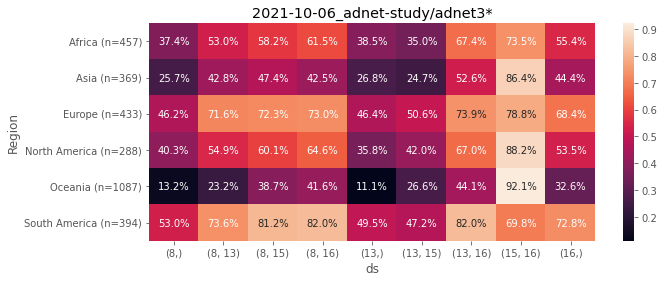

In [62]:
f, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    df_user_vuln,
    annot=True,
    fmt='.1%',
    ax=ax,
)
plt.title('2021-10-06_adnet-study/adnet3*')
plt.savefig('adnet3-vulnerabilities-by-region-and-ds-config.pdf')

In [39]:
df_user_vuln = df_requests[df_requests['attack'] != 'mitm-ra'].groupby(['Region', 'token', 'ds']).agg(
    {'vulnerable': [any]}  # aggregation across attacks, hence using any
).reset_index()
df_user_vuln.columns = df_user_vuln.columns.droplevel(1)
df_user_vuln = df_user_vuln.pivot(index=['Region', 'token'], columns=['ds'], values=['vulnerable'])
df_user_vuln.head(20).style.apply(lambda row: ['background-color: red;' if val else '' for val in row], axis=1)

/home/nils/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [40]:
df_user_behaviors = df_user_vuln.reset_index().groupby(list(sorted(df_user_vuln.keys()))).agg({('token', ''): ['count']}).reset_index().sort_values(('token', '', 'count'), ascending=False)
df_user_behaviors.head(30).style.apply(lambda row: ['background-color: red;' if val < 1 else '' for val in row], axis=1).format(lambda v: f"{v:n}")

In [41]:
len(df_requests['token'].unique())

3028

In [42]:
df_user_behaviors = df_user_vuln.reset_index().groupby(list(sorted(df_user_vuln.keys()))).agg({('token', ''): ['count']}).reset_index().sort_values(('token', '', 'count'), ascending=False)
df_user_behaviors.head(30).style.apply(lambda row: ['background-color: red;' if val < 1 else '' for val in row], axis=1).format(lambda v: f"{v:n}")

In [43]:
behaviors = sorted()
df_user_vuln['behavior'] = df_user_vuln.apply(lambda row: ''.join(['0' if row[k] < 1 else '1' for k in behaviors]), axis=1)

TypeError: sorted expected 1 argument, got 0

In [ ]:
df_user_vuln.reset_index().groupby(['behavior']).agg({('token', '', ''): ['count']}).reset_index().sort_values(('token', '', '', 'count'), ascending=False).head(30)

In [ ]:
behaviors[-6]